# Semi-supervised Generative Adversarial Networks

To understand intution behind this model follow this blog:
1. [Implementing semi-supervised Learning using GANs](https://theailearner.com/2019/09/16/implementing-semi-supervised-learning-using-gans/)

## Introduction

Generative Adversarial Networks - in GANs, we train two networks adversely, generator and discriminator. And the adversary is, while the generator tries to generate data similar to original data distribution, discriminator tries to discriminate between data generated by the generator and original data. Here generator will try to fool the discriminator by improving itself and discriminator tries to differentiate between original and fake. This training will continue until the discriminator model is fooled half the time and the generator is able to generate data similar to original data distribution.

Semi-supervised GAN - In GANs, after training the GAN network we discard the discriminator and only use generator network to generate the new data. Now in the semi-supervised model after training the network we will discard the generator model and use the discriminator model. But here the discriminator model is designed differently.
In semi-supervised GAN (SGAN) discriminator is not only trained to discriminate between real and fake data but also to predict the label for the input image.

### Imports and Initialize Parameters

In [1]:
from keras.layers import Input, Dense, Reshape, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np

Using TensorFlow backend.


In [2]:
import tensorflow as tf

#ignore warnings in the output
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
batch_size = 100
half_batch_size = 50
latent_dim = 100
iterations = 10000
optimizer = Adam(0.0002, 0.5)

### Generator in SGAN

Generator in this SGAN is a simple multi-layer neural network having three hidden layers with units 512, 256 and 128. The output layer is having a shape of the original image (28, 28,1). Input to the generator will we random noise of vector size 100.

In [4]:
def generator():

    input_gen = Input(shape=(latent_dim,))
    hidden1 = BatchNormalization(momentum=0.8)(Dense(256, activation='relu')(input_gen))
    hidden2 = BatchNormalization(momentum=0.8)(Dense(512, activation='relu')(hidden1))
    hidden3 = BatchNormalization(momentum=0.8)(Dense(1024, activation='relu')(hidden2))
    output = Dense(784, activation='tanh')(hidden3)
    reshaped_output = Reshape((28, 28, 1))(output)
    gen_model = Model(input_gen, reshaped_output)
    gen_model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return gen_model

In [5]:
generator_model = generator()
generator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
__________

### Discriminator in SGAN

For this semi-supervised GAN model, we will create two discriminator models both of them share weights of every layer but have different output layers. One model will be the binary classifier model (discriminate between real and fake images) and another will be multi-class classifier model (predicts labels for the input image).

In [6]:
def discriminator():

    input_disc = Input(shape=(784,))
    hidden1 = Dense(512, activation='relu')(input_disc)
    hidden2 = Dense(256, activation='relu')(hidden1)
    hidden3 = Dense(128, activation='relu')(hidden2)
    output = Dense(1, activation='sigmoid')(hidden3)
    output2 = Dense(10, activation='softmax', name='classification_layer')(hidden3)
    disc_model = Model(input_disc, output)
    disc_model_2 = Model(input_disc, output2)
    disc_model.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
    disc_model_2.compile(loss=['categorical_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

    return disc_model, disc_model_2

In [7]:
discriminator_model, classification_model = discriminator()

In [8]:
print('****************************Discriminator Model*********************************')
discriminator_model.summary()

****************************Discriminator Model*********************************
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 566,273
Trainable params: 566,273
Non-trainable params: 0
_________________________________________________________________


In [9]:
print('****************************Classification Model*********************************')
classification_model.summary()

****************************Classification Model*********************************
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
classification_layer (Dense) (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


In [10]:
def combined():

    inputs = Input(shape=(latent_dim,))
    gen_img = generator_model(inputs)
    gen_img = Reshape((784,))(gen_img)
    discriminator_model.trainable = False
    outs = discriminator_model(gen_img)
    comb_model = Model(inputs, outs)
    comb_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(comb_model.summary())

    return comb_model

In [11]:
combined_model = combined()
combined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         1493520   
_________________________________________________________________
reshape_2 (Reshape)          (None, 784)               0         
_________________________________________________________________
model_2 (Model)              (None, 1)                 566273    
Total params: 2,059,793
Trainable params: 1,489,936
Non-trainable params: 569,857
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_______________________________________________________

### Sample The Dataset

MNIST digits dataset consists of 60000 training images from which we will only use 1000 labeled images and rest as unlabeled images. We will select random 1000 labeled images containing 100 images for each class.

In [12]:
def sample_1000(x, y):

    x_1000 = []
    y_1000 = []
    for i in range(10):
        x_i = x[y == i]
        ix = np.random.randint(0, len(x_i), 100)
        [x_1000.append(x_i[j]) for j in ix]
        [y_1000.append(i) for j in ix]

    return x_1000, y_1000

### Training the model

Training this model will consist of the following steps:

1. Sample both label and unlabeled data from the MNIST dataset, also normalize and make labels of data into categorical form.
2. Train the multi-class discriminator model with labeled real images (take a batch from images)
3. Train the binary-class discriminator model with unlabeled real images (take a batch from images)
4. Sample noise of vector size 100 and train the binary-class discriminator model with fake images generated by generator network.
5. Sample noise of vector size 100 and train the combined model to train the generator network.
6. Repeat steps from 2-5 for some number of iterations. I have trained it for 10000 iterations.

In [13]:
def train():

    train_data, train_data_y = sample_1000(x_train, y_train)
    train_data = ((np.array(train_data).astype(np.float32)) - 127.5) / 127.5
    train_data_y = to_categorical(train_data_y)

    all_train_data = ((np.array(x_train).astype(np.float32)) - 127.5) / 127.5
    all_train_data_y = to_categorical(y_train)

    for j in range(iterations):

        batch_indx = np.random.randint(0, train_data.shape[0], size=(half_batch_size))
        batch_x = train_data[batch_indx]
        batch_x = batch_x.reshape((-1, 784))
        batch_y = train_data_y[batch_indx]

        batch_indx_total = np.random.randint(0, all_train_data.shape[0], size=(half_batch_size))
        batch_x_total = all_train_data[batch_indx_total]
        batch_x_total = batch_x_total.reshape((-1, 784))
        batch_y_total = all_train_data_y[batch_indx_total]

        input_noise = np.random.normal(0, 1, size=(half_batch_size, 100))
        gen_outs = generator_model.predict(input_noise)
        gen_outs = gen_outs.reshape((-1, 784))

        classi_loss = classification_model.train_on_batch(batch_x, batch_y)
        real_loss1 = discriminator_model.train_on_batch(batch_x_total, np.ones((half_batch_size, 1)))
        fake_loss = discriminator_model.train_on_batch(gen_outs, np.zeros((half_batch_size, 1)))

        full_batch_input_noise = np.random.normal(0, 1, size=(batch_size, 100))
        gan_loss = combined_model.train_on_batch(full_batch_input_noise, np.array([1] * batch_size))

        if j % 1000 == 0:
            test_data = ((x_test.astype(np.float32) - 127.5) / 127.5).reshape((-1, 784))
            test_results = classification_model.predict(test_data)
            test_results_argmax = np.argmax(test_results, axis=1)

            count = 0
            for i in range(len(test_results_argmax)):
                if test_results_argmax[i] == y_test[i]:
                    count += 1
            print("Accuracy After", j, "iterations: ", (count / len(test_data)) * 100)

In [15]:
if __name__ == '__main__':
    train()

Accuracy After 0 iterations:  76.0
Accuracy After 1000 iterations:  90.60000000000001
Accuracy After 2000 iterations:  91.9
Accuracy After 3000 iterations:  92.93
Accuracy After 4000 iterations:  93.17999999999999
Accuracy After 5000 iterations:  94.03
Accuracy After 6000 iterations:  94.05
Accuracy After 7000 iterations:  94.33
Accuracy After 8000 iterations:  94.65
Accuracy After 9000 iterations:  94.55


predicted labels for generated images
1 5 5 1 1 0 4 4 3 7 6 9 6 2 4 4 4 6 7 3 7 3 0 4 0 

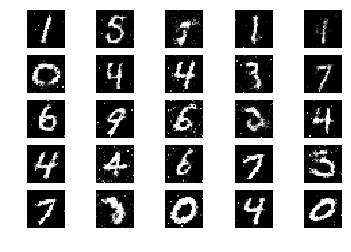

In [17]:
import matplotlib.pyplot as plt

r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, 100))
gen_imgs = generator_model.predict(noise)
new_gen_img = gen_imgs.reshape(25, 784)

output_class = classification_model.predict(new_gen_img)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c)
cnt = 0
print('predicted labels for generated images')
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        print(np.argmax(output_class[cnt]), end=' ')
        axs[i,j].axis('off')
        cnt += 1
        
plt.show()
fig.savefig("mnist.png")
plt.close()